In [1]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
#from ImageDataset import ImageDataset
from image_dataset import ImageDataset
from torch import nn
import torch

# Set the path to the folder containing your unlabeled images
train_path = "data/DIV2K/train"
test_path = "data/DIV2K/valid"

# Define the transformation to be applied to each image
transform = transforms.Compose([
    #transforms.Resize((256, 256)),  # Resize the image to a fixed size
    transforms.RandomCrop((256,256)),
    transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomRotation(45),
    transforms.ToTensor()  # Convert the image to a tensor
])

# Create the ImageFolder dataset
train_data = ImageDataset(train_path, transform=transform)

test_data = ImageDataset(test_path, transform=transform)

In [2]:
from torch.utils.data import DataLoader
train_data_loader = DataLoader(dataset=train_data, 
                              batch_size=8, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_data_loader = DataLoader(dataset=test_data, 
                              batch_size=8, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

In [12]:
from train_autoencoder import downsample_image
batch = next(iter(test_data_loader))


In [28]:
i = 4
hr_img = batch[i]
lr_img = downsample_image(hr_img.unsqueeze(0), factor=4).squeeze()

(-0.5, 127.5, 127.5, -0.5)

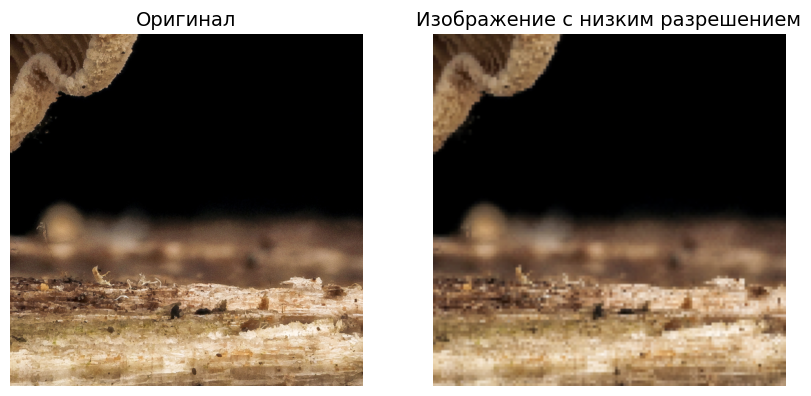

In [29]:
plt.figure(figsize=(10, 7))

plt.subplot(1, 2, 1)
plt.imshow(hr_img.permute(1, 2, 0))
plt.title("Оригинал", fontsize=14, c="black")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(lr_img.permute(1, 2, 0), resample=False, interpolation=None)
plt.title("Изображение с низким разрешением", fontsize=14, c="black")
plt.axis("off")

In [59]:
import os
from PIL import Image, ImageFilter

transform_image = transforms.Compose([
    #transforms.Resize((256, 256)),  # Resize the image to a fixed size
    #transforms.RandomCrop((256,256)),
    #transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomRotation(45),
    transforms.ToTensor()  # Convert the image to a tensor
])

def load_image(image_path, transform=transform_image):
    image = Image.open(image_path)

    if transform:
        image = transform(image)
    return image

torch.Size([4, 20, 20])


(-0.5, 19.5, 19.5, -0.5)

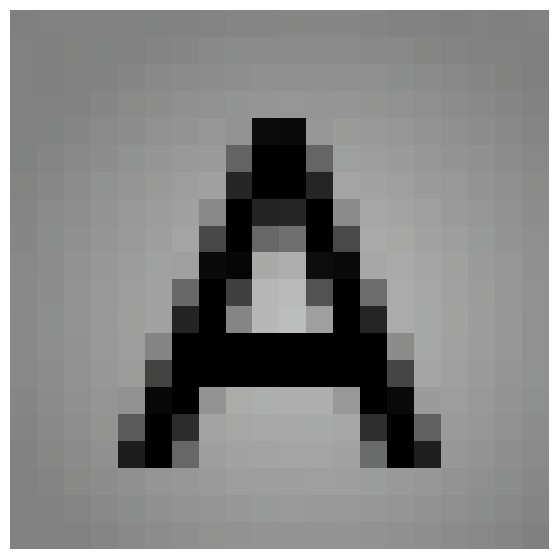

In [60]:
img_a = downsample_image(load_image(r"F:\DZ\diploma\closest_pixel.png").unsqueeze(0), factor=10).squeeze()

print(img_a.shape)
plt.figure(figsize=(10, 7))
plt.imshow(img_a.permute(1, 2, 0))
#plt.title("Оригинал", fontsize=14, c="black")
plt.axis("off")

In [68]:
from pathlib import Path
# Create models directory (if it doesn't already exist), see: https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "autoencoder_upsampler_res_blocks_2.pth"
#MODEL_NAME = "residual_upsampler_ssim_150.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

In [69]:
#from autoencoder_upscale_model import AutoencoderUpscaleModel
import torch
from residual_upsampler_2 import ResidualUpsampler2
#from my_upscale_model import UpscaleModel
from my_upscale_model2 import UpscaleModel2
##from autoencoder_upsampler_2 import AutoencoderUpsampler2
from train_autoencoder import downsample_image

device = "cpu"

batch = img_a.unsqueeze(0)

if batch.shape[1] == 4:
    batch = batch[:, :3, :, :]

#model = UpscaleModel2()
#model = AutoencoderUpsampler2()
model = ResidualUpsampler2()

model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

model.to(device)

#img = downsample_image(batch, 4)
model.eval()
with torch.inference_mode():
    result = model(batch.to(device)).squeeze()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 80, 80])
torch.Size([3, 80, 80])


(-0.5, 79.5, 79.5, -0.5)

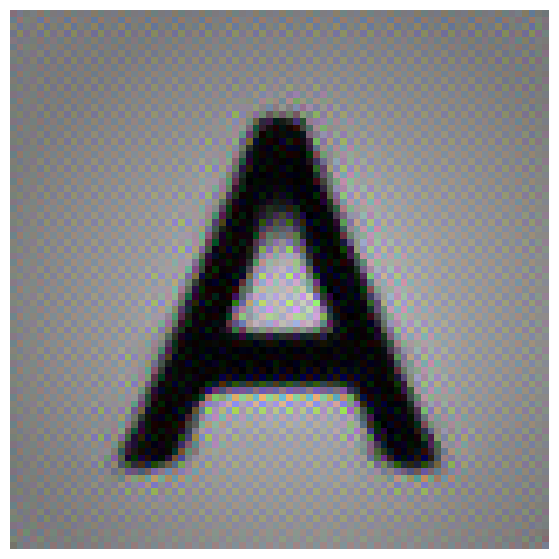

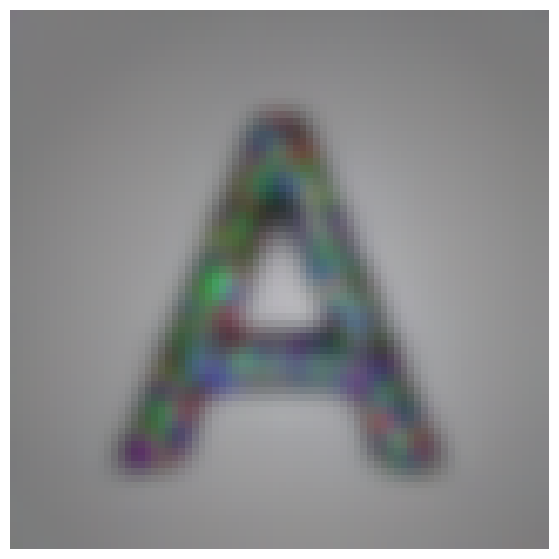

In [70]:
output_image = transforms.ToPILImage()(result.squeeze().cpu())

# Apply Gaussian filter to the output image
filtered_image = output_image.filter(ImageFilter.GaussianBlur(radius=1.5))

# Convert the filtered image back to a tensor
filtered_tensor = transforms.ToTensor()(filtered_image)

print(result.shape)
plt.figure(figsize=(10, 7))
plt.imshow(result.permute(1, 2, 0))
#plt.title("Оригинал", fontsize=14, c="black")
plt.axis("off")

print(result.shape)
plt.figure(figsize=(10, 7))
plt.imshow(filtered_tensor.permute(1, 2, 0))
#plt.title("Оригинал", fontsize=14, c="black")
plt.axis("off")